In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import psutil
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

In [2]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'

In [3]:
file = os.path.join(root_path, 'fly_21', 'func_0', 'imaging', 'functional.nii')
brain = bbb.load_numpy_brain(file)
print(np.shape(brain))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 32.30 sec
(128, 79, 53, 4370, 2)


In [ ]:
file = os.path.join(root_path, 'fly_23', 'func_0', 'imaging', 'functional.nii')
brain = bbb.load_numpy_brain(file)
print(np.shape(brain))


~~ load_numpy_brain ~~


In [3]:
expt_len = 1000*30*60
fps = 50 #of fictrac camera

In [4]:
expts = ['fly_1/func_0',
         'fly_2/func_0',
         'fly_3/func_0',
         'fly_5/func_0',
         'fly_6/func_0',
         'fly_8/func_0',
         'fly_9/func_0',
         'fly_10/func_0',
         'fly_13/func_0',
         'fly_14/func_0',
         'fly_17/func_0',
         'fly_21/func_0',
         'fly_23/func_0',
         'fly_25/func_0',
         'fly_26/func_0']

In [25]:
fly_nums = [1,2,3,5,6,8,9,10,13,14,17,21,23,25,26]

In [5]:
fic = []
for expt in expts:
    # Load data
    print('Starting {}'.format(expt))
    directory = os.path.join(root_path, expt)
    fic.append(bbb.load_fictrac(os.path.join(directory, 'fictrac')))

Starting fly_1/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 3.04 sec
Starting fly_2/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 2.98 sec
Starting fly_3/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 3.09 sec
Starting fly_5/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 3.03 sec
Starting fly_6/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 3.05 sec
Starting fly_8/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 3.08 sec
Starting fly_9/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 3.01 sec
Starting fly_10/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 3.03 sec
Starting fly_13/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 3.01 sec
Starting fly_14/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 3.06 sec
Starting fly_17/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 3.12 sec
Starting fly_21/func_0

~~ load_fictrac ~~
load_fictrac done. Duration: 2.96 sec
Starting fly_23/func_0

~~ load_fic

In [9]:
fic = np.asarray(fic)

ValueError: cannot copy sequence with size 90000 to array axis with dimension 23

In [10]:
for i in range(15):
    print(np.shape(fic[i]))

(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)
(90000, 23)


In [13]:
fic_v = []
for i in range(15):
    dx = np.asarray(fic[i]['dRotLabX'])
    dy = np.asarray(fic[i]['dRotLabY'])
    dz = np.asarray(fic[i]['dRotLabZ'])
    dx = scipy.ndimage.filters.gaussian_filter(dx,sigma=3)
    dy = scipy.ndimage.filters.gaussian_filter(dy,sigma=3)
    dz = scipy.ndimage.filters.gaussian_filter(dz,sigma=3)
    fic_v.append(np.sqrt(dx*dx + dy*dy + dz*dz))

In [14]:
fic_v = np.asarray(fic_v)

In [15]:
fic_v.shape

(15, 90000)

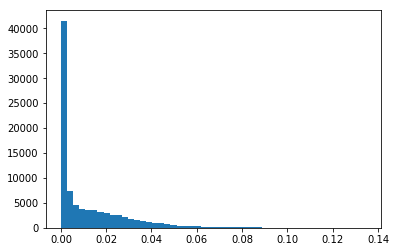

In [19]:
plt.hist(fic_v[0,:],bins=50);

In [20]:
means = np.mean(fic_v, axis=-1)

In [39]:
fly_nums_sorted=[str(x) for _,x in sorted(zip(means,fly_nums))]

<BarContainer object of 15 artists>

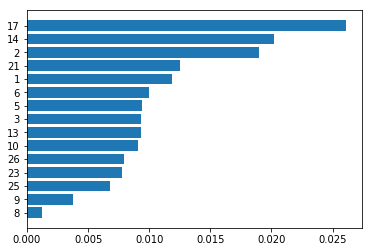

In [151]:
plt.barh(y=fly_nums_sorted, width=sorted(means))

In [144]:
fly_nums_sorted

['8',
 '9',
 '25',
 '23',
 '26',
 '10',
 '13',
 '3',
 '5',
 '6',
 '1',
 '21',
 '2',
 '14',
 '17']

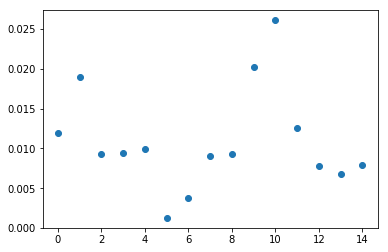

In [42]:
plt.plot(means,'o')

In [43]:
fly_nums

[1, 2, 3, 5, 6, 8, 9, 10, 13, 14, 17, 21, 23, 25, 26]

In [112]:
zs = [17, 15, 22, 12, 14, 21, 17, 13, 12, 21, 21, 16, 17, 21, 23]

In [49]:
glm_names = ['multivariate_analysis_green_speed.nii',
             'multivariate_analysis_green_speed.nii',
             'multivariate_analysis_green_speed.nii',
             'multivariate_analysis_green_speed.nii',
             'multivariate_analysis_green_speed.nii',
             'multivariate_analysis_green_speed.nii',
             'multivariate_analysis_green_speed.nii',
             'multivariate_analysis_green_speed.nii',
             'multivariate_analysis_green.nii',
             'multivariate_analysis_green.nii',
             'multivariate_analysis_green.nii',
             'multivariate_analysis_green.nii',
             'multivariate_analysis_green.nii',
             'multivariate_analysis_green_speed_fictracsigma5.nii',
             'multivariate_analysis_green_speed.nii']

In [52]:
spatial_pcs = []
ccs = []
glms = []
for i,expt in enumerate(expts):
    # Load data
    print('Starting {}'.format(expt))
    
    try:
        # Load spatial PCs
        file = os.path.join(root_path, expt, 'pca', 'spatial_PCs.nii')
        spatial_pcs.append(bbb.load_numpy_brain(file))

        # Load CC
        file = os.path.join(root_path, expt, 'pca', 'cross_corr.npy')
        ccs.append(np.load(file))
    except:
        print('failed')
        spatial_pcs.append(None)
        ccs.append(None)
    
    # Load GLM
    file = os.path.join(root_path, expt, 'glm', glm_names[i])
    glms.append(bbb.load_numpy_brain(file))

Starting fly_1/func_0

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 167.94 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 11.29 ms
Starting fly_2/func_0

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 110.46 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 31.93 ms
Starting fly_3/func_0

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 117.73 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 244.18 ms
Starting fly_5/func_0

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 170.79 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 470.88 ms
Starting fly_6/func_0

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 120.33 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 456.75 ms
Starting fly_8/func_0

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 198.53 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 52.08 ms
Starting fly_9/func_0

~~ load_numpy_brain ~~
load_numpy_brain done

In [57]:
timestamps = []
for i,expt in enumerate(expts):
    # Load data
    print('Starting {}'.format(expt))
    
    try:
        # Load spatial PCs
        file = os.path.join(root_path, expt, 'imaging')
        timestamps.append(bbb.load_timestamps(file))
    except:
        print('failed')
        timestamps.append(None)

Starting fly_1/func_0

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 980.56 ms
Starting fly_2/func_0

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 48.20 ms
Starting fly_3/func_0

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 97.60 ms
Starting fly_5/func_0

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 44.73 ms
Starting fly_6/func_0

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 79.04 ms
Starting fly_8/func_0

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 42.13 ms
Starting fly_9/func_0

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 118.41 ms
Starting fl

In [ ]:
len()

In [94]:
np.shape(glms[0])

(88, 128, 55)

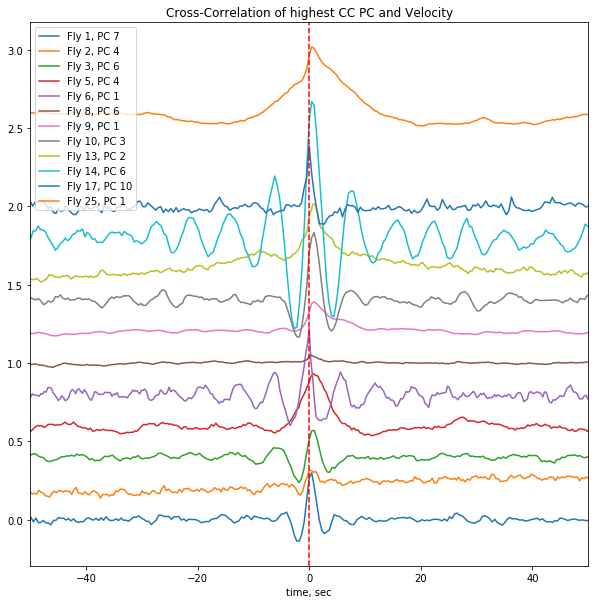

In [130]:
plt.figure(figsize=(10,10))
plt.title('Cross-Correlation of highest CC PC and Velocity')

for i in range(15):
    try:
        #corred = ccs[i][pcs[i],:]
        corred = ccs[i][np.argmax(cc_max[i]),:]
        Hz = np.diff(timestamps[i][:,1])[0]
        dur = len(timestamps[i][:,1])
        bins = bbb.create_bins(Hz,Hz*dur,Hz*dur)
        plt.plot(bins[1:-1]/1000,corred+(.2*i),label='Fly {}, PC {}'.format(fly_nums[i], np.argmax(cc_max[i])+1))
    except:
        pass
plt.xlim(-50,50)
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('time, sec')
plt.legend(loc=2)
plt.show()

In [122]:
cc_max = []
for i in range(15):
    cc_max.append(np.max(ccs[i],axis=-1))

In [125]:
np.argmax(cc_max[0])

6

In [115]:
pcs = [4/5,4/5,3,3/4,1/3/5,None,1/2,0,0,0,0,0,0,0,0]

In [ ]:
pcs = [pick highest max]

In [133]:
spatial_pcs[0].shape

(88, 128, 55, 10)

### Lets plot the same-ish slice from each brain for each PC

In [109]:
rotate = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1]

In [ ]:
plt.barh(y=fly_nums_sorted, width=sorted(means))

In [152]:
fly_nums_sorted

['8',
 '9',
 '25',
 '23',
 '26',
 '10',
 '13',
 '3',
 '5',
 '6',
 '1',
 '21',
 '2',
 '14',
 '17']

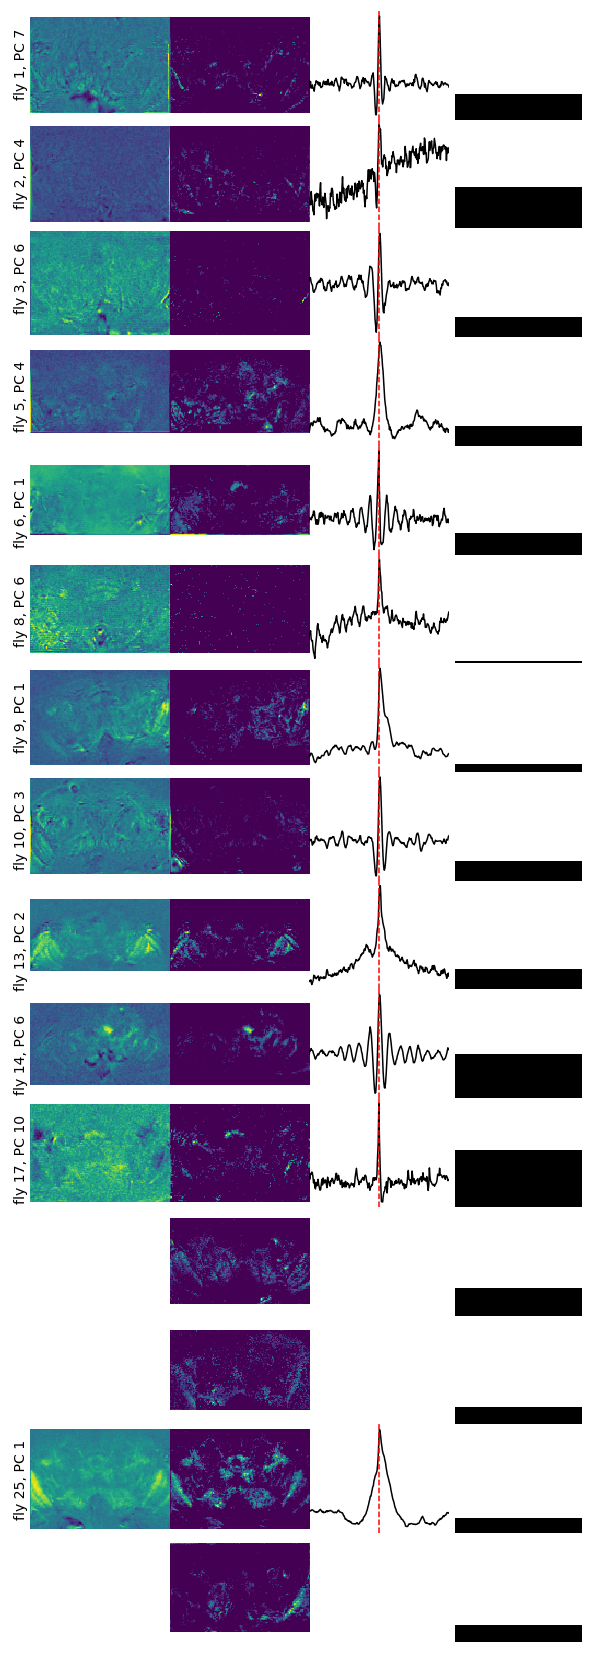

In [190]:
plt.figure(figsize=(10,30))

num_rows = 4

for i in range(15):
    
    # Plot Spatial PC map
    plt.subplot(15,num_rows,i*num_rows+1)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    try:
        if rotate[i] == 1:
            plt.imshow(spatial_pcs[i][:,:,zs[i],np.argmax(cc_max[i])].T)
        else:
            plt.imshow(spatial_pcs[i][:,:,zs[i],np.argmax(cc_max[i])])
        #plt.title('fly {}, PC {}'.format(fly_nums[i], np.argmax(cc_max[i])+1),loc=)
        plt.text(-15, 20, 'fly {}, PC {}'.format(fly_nums[i], np.argmax(cc_max[i])+1),
                fontsize=14,
                #verticalalignment='top',
                rotation=90)
    except:
        pass
    
    # Plot glm map
    plt.subplot(15,num_rows,i*num_rows+2)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    try:
        if rotate[i] == 1:
            plt.imshow(glms[i][:,:,zs[i]].T)
        else:
            plt.imshow(glms[i][:,:,zs[i]])
    except:
        pass
    
    # Plot temporal PC
    plt.subplot(15,num_rows,i*num_rows+3)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    try:
        corred = ccs[i][np.argmax(cc_max[i]),:]
        Hz = np.diff(timestamps[i][:,1])[0]
        dur = len(timestamps[i][:,1])
        bins = bbb.create_bins(Hz,Hz*dur,Hz*dur)
        plt.plot(bins[1:-1]/1000,corred,label='Fly {}, PC {}'.format(fly_nums[i], np.argmax(cc_max[i])+1),color='k')
        plt.xlim(-50,50)
        plt.axvline(0,linestyle='--',color='r')
    except:
        pass
    
    # Plot fly speed
    plt.subplot(15,num_rows,i*num_rows+4)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    try:
        plt.bar(x=0, height=means[i],color='k')
        plt.ylim(0,.05)
    except:
        pass